1.Define warehouse robot environment

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt

In [2]:


class GridWorld(gym.Env):
    def __init__(self, start_position=(0, 0), goal_position=(5, 5), item_positions=None):
        super().__init__()

        # Grid dimensions
        self.grid_size = 6
        self.state_space = self.grid_size * self.grid_size
        # Action space: only Up, Down, Left, Right
        self.action_space = spaces.Discrete(4)
        self.action_names = ["Up", "Down", "Right", "Left"]
        # 2 states per grid for carrying object or not
        self.observation_space = spaces.Discrete(self.state_space * 2)
        self.rewards = np.zeros((self.grid_size, self.grid_size))

        # assign a reward of 25 , at various postions where the warehouse agent has to pick up items
        if item_positions is not None:
            for pos in item_positions:
                row, col = pos
                if 0 <= row < self.grid_size and 0 <= col < self.grid_size:
                    self.rewards[row, col] = 25

        # assign a reward of 100, for dropping off the items
        self.rewards[goal_position] = 100

        # Obstacle Shelves postions
        self.obstacles = [(2, 2), (3, 3), (4, 4)]

        self.state = start_position
        self.total_reward = 0
        self.goal_position = goal_position
        self.start_position = start_position
        self.carrying_object = False

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(np.arange(0, self.grid_size, 1))
        ax.set_yticks(np.arange(0, self.grid_size, 1))   
        ax.grid(True, which='both', color='black', linewidth=2)
        ax.set_xticklabels([]) 
        ax.set_yticklabels([]) 
        ax.set_aspect('equal')
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                reward = self.rewards[i, j]
                if (i, j) in self.obstacles:
                    ax.text(j + 0.5, self.grid_size - 1 - i + 0.5, 'X', ha='center', va='center', color='red', fontsize=12)
                elif reward != 0:
                    ax.text(j + 0.5, self.grid_size - 1 - i + 0.5, f'{reward}', ha='center', va='center', color='blue', fontsize=12)
        start_row, start_col = self.start_position
        ax.text(start_col + 0.5, self.grid_size - 1 - start_row + 0.5, 'S', ha='center', va='center', color='green', fontsize=14)
        goal_row, goal_col = self.goal_position
        ax.text(goal_col + 0.5, self.grid_size - 1 - goal_row + 0.5, 'G', ha='center', va='center', color='purple', fontsize=14)
        agent_row, agent_col = self.state
        ax.text(agent_col + 0.5, self.grid_size - 1 - agent_row + 0.5, '•', ha='center', va='center', color='black', fontsize=16)
        plt.show()

    def step(self, action):
        row, col = self.state
        old_state = self.state
        if action == 0:  # Up
            row = max(0, row - 1)
        elif action == 1:  # Down
            row = min(self.grid_size - 1, row + 1)
        elif action == 2:  # Right
            col = min(self.grid_size - 1, col + 1)
        elif action == 3:  # Left
            col = max(0, col - 1)

        # If there is a collision, return the old state and penalize the agent
        if (row, col) in self.obstacles:            
            self.state = old_state
            return self.state, self.total_reward - 20, False, False, {}
        
        self.state = (row, col)

        # If the agent steps on a item it picks it up and carrying_object is set to True 
        reward_collected = self.rewards[row, col]
        if reward_collected == 25:
            self.total_reward += 25
            self.rewards[row, col] = 0
            self.carrying_object = True
        
        # Check if the goal state is reached
        done = False
        if self.state == self.goal_position:
            # If the agent reaches the destination mark it as done
            #it adds 100 points to its total reward for dropping off  only if it is carrying some item
            if self.carrying_object == True:
                self.total_reward += 100            
            done = True

        
        # Penalty
        self.total_reward -= 1
        
        return self.state, self.total_reward, done, False, {}

    def reset(self, start_position, goal_position, item_positions):
        self.state = start_position
        self.total_reward = 0
        self.goal_position = goal_position
        self.carrying_object = False
        self.rewards = np.zeros((self.grid_size, self.grid_size))
        if item_positions is not None:
            for item_pos in item_positions:
                row, col = item_pos
                if 0 <= row < self.grid_size and 0 <= col < self.grid_size:
                    self.rewards[row, col] = 25
        self.rewards[self.goal_position] = 100
        
        return self.state

    def get_observation(self):
        return (self.state, self.carrying_object)

    def get_state_index(self):
        return self.state[0] * self.grid_size + self.state[1] + (1 if self.carrying_object else 0) * self.state_space


2.Run a random agent for at least 10 timesteps

Initial State


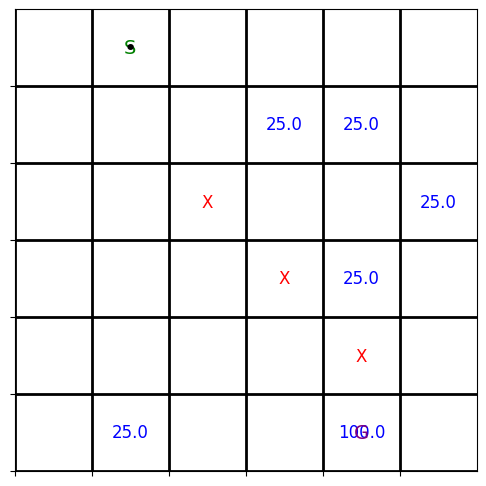


Running for 10 steps with Random action:
State: (0, 1), Next State: (0, 2), Action: Right, Reward: -1, Iteration: 1


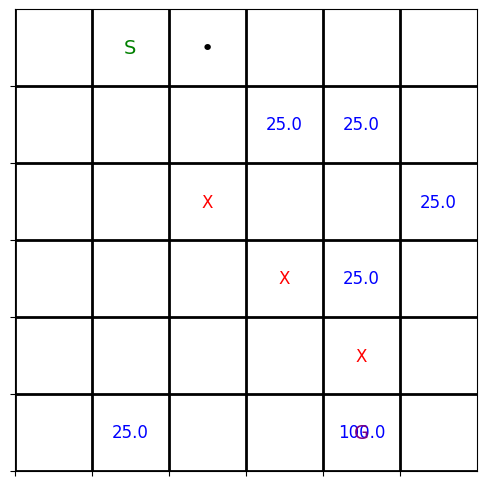

State: (0, 2), Next State: (0, 2), Action: Up, Reward: -2, Iteration: 2
No movement. Reward not updated.


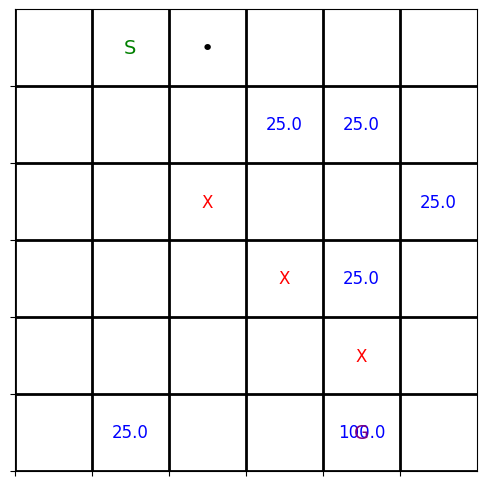

State: (0, 2), Next State: (1, 2), Action: Down, Reward: -3, Iteration: 3


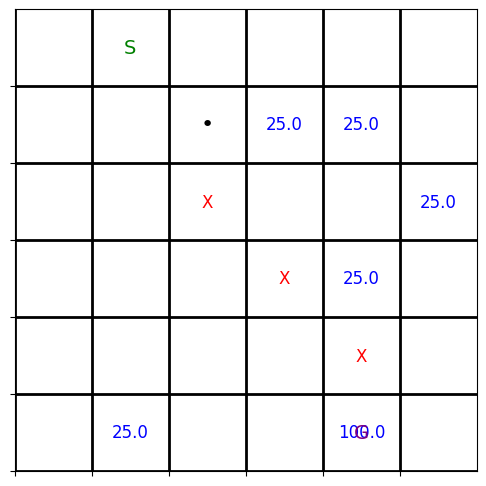

State: (1, 2), Next State: (1, 3), Action: Right, Reward: 21, Iteration: 4


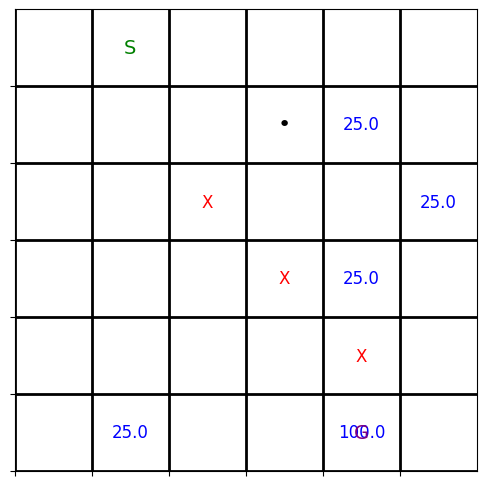

State: (1, 3), Next State: (0, 3), Action: Up, Reward: 20, Iteration: 5


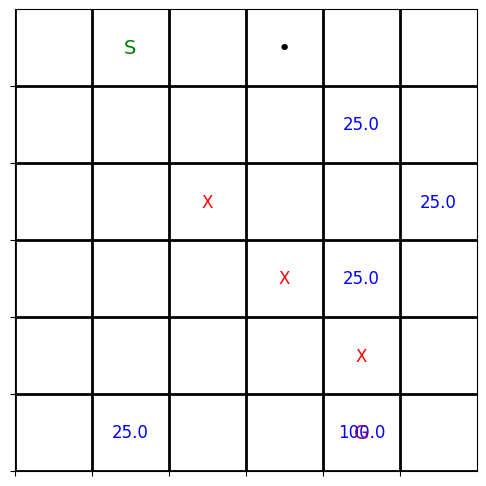

State: (0, 3), Next State: (0, 2), Action: Left, Reward: 19, Iteration: 6


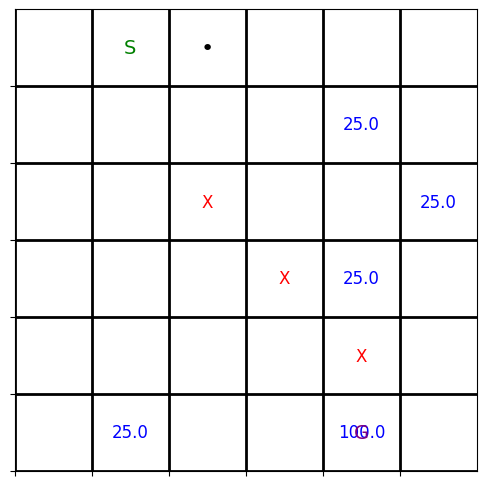

State: (0, 2), Next State: (0, 2), Action: Up, Reward: 18, Iteration: 7
No movement. Reward not updated.


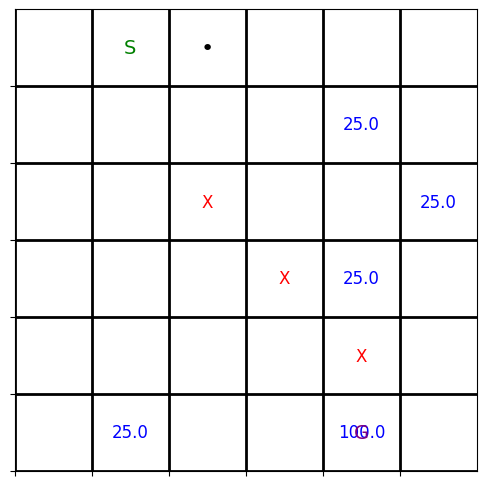

State: (0, 2), Next State: (0, 2), Action: Up, Reward: 17, Iteration: 8
No movement. Reward not updated.


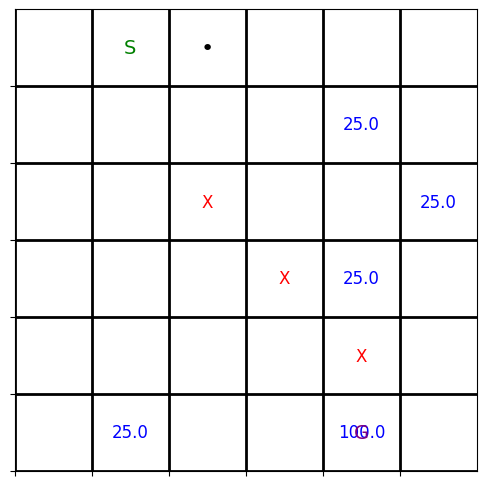

State: (0, 2), Next State: (0, 1), Action: Left, Reward: 16, Iteration: 9


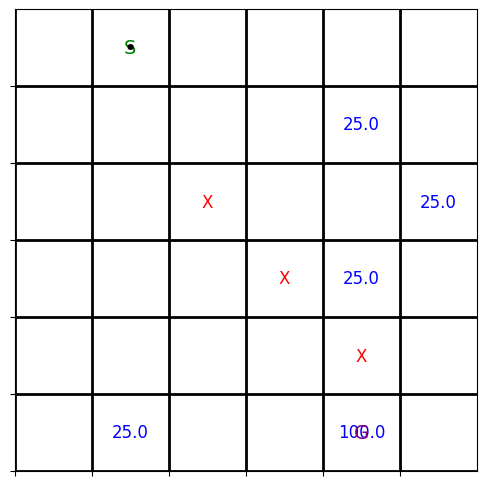

State: (0, 1), Next State: (0, 1), Action: Up, Reward: 15, Iteration: 10
No movement. Reward not updated.


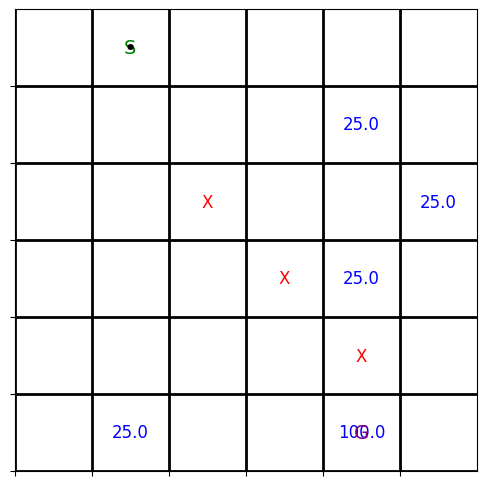

In [3]:

# Specify item positions where agent will have items
item_positions = [(1, 4), (2, 5), (3, 4), (1, 3), (5, 1)]
# Specify start postion , end position
start_position=(0, 1)
goal_position=(5, 4)
env = GridWorld(start_position, goal_position, item_positions)

state = env.reset(start_position,goal_position,item_positions)
print("Initial State")
env.render()

print("\nRunning for 10 steps with Random action:")
for iteration in range(10):
    action = env.action_space.sample()
    next_state, total_reward, done, _, _ = env.step(action)
    action_name = env.action_names[action]    
    print(f"State: {state}, Next State: {next_state}, Action: {action_name}, Reward: {total_reward}, Iteration: {iteration + 1}")
    if state == next_state:
        print("No movement. Reward not updated.")    
    env.render()    
    state = next_state
    if done:
        print("Item delivered!")
        break


3.Solve this environment using SARSA

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [5]:


def epsilon_greedy(Q, state, epsilon, num_actions):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, num_actions - 1)
    else:
        return np.argmax(Q[state[0] * 6 + state[1]])

# SARSA Approach implementation
def sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay, start_position, goal_position, item_positions):
    Q = np.random.uniform(low=0.00, high=0.02, size=(env.state_space, env.action_space.n))
    goal_state_index = goal_position[0] * 6 + goal_position[1]
    # Set goal state Q-values to 0
    Q[goal_state_index, :] = 0
    total_rewards = []
    epsilon_values = []
    initial_Q = Q.copy()

    for episode in range(episodes):
        state = env.reset(start_position, goal_position, item_positions)
        action = epsilon_greedy(Q, state, epsilon, env.action_space.n)
        total_reward = 0
        done = False

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon, env.action_space.n)
            next_state_index = next_state[0] * 6 + next_state[1]
            if next_state != goal_position:
                Q[state[0] * 6 + state[1], action] += alpha * (reward + discount * Q[next_state_index, next_action] - Q[state[0] * 6 + state[1], action])
            state, action = next_state, next_action
            total_reward += reward

        Q[goal_state_index, :] = 0

        total_rewards.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)

    return Q, initial_Q, total_rewards, epsilon_values


Initial Q-table:
                    Up      Down     Right      Left
State (0, 0)  0.008284  0.007581  0.016175  0.007596
State (0, 1)  0.016632  0.012003  0.018704  0.007236
State (0, 2)  0.010158  0.017566  0.015752  0.007004
State (0, 3)  0.000108  0.016226  0.011999  0.013645
State (0, 4)  0.003247  0.010998  0.019809  0.007977
State (0, 5)  0.017645  0.003419  0.019849  0.004369
State (1, 0)  0.009821  0.001050  0.018301  0.009490
State (1, 1)  0.000080  0.000021  0.008272  0.016360
State (1, 2)  0.009978  0.010911  0.013032  0.003774
State (1, 3)  0.014919  0.002847  0.002657  0.010249
State (1, 4)  0.010816  0.016102  0.004585  0.018276
State (1, 5)  0.004095  0.001436  0.013525  0.017638
State (2, 0)  0.018667  0.004100  0.006862  0.009342
State (2, 1)  0.006546  0.006524  0.012099  0.005449
State (2, 2)  0.007053  0.005841  0.005848  0.010094
State (2, 3)  0.002415  0.014575  0.018182  0.003724
State (2, 4)  0.014145  0.003635  0.015979  0.008491
State (2, 5)  0.001589  0.005

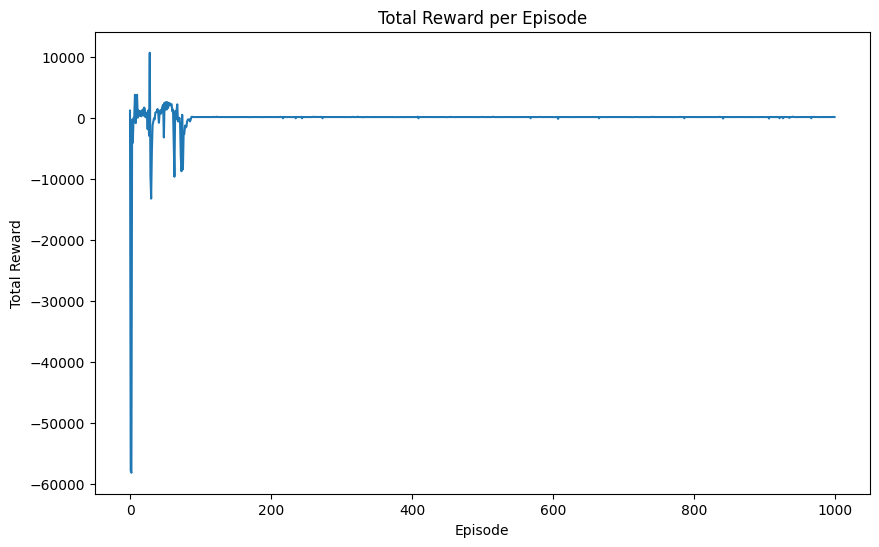

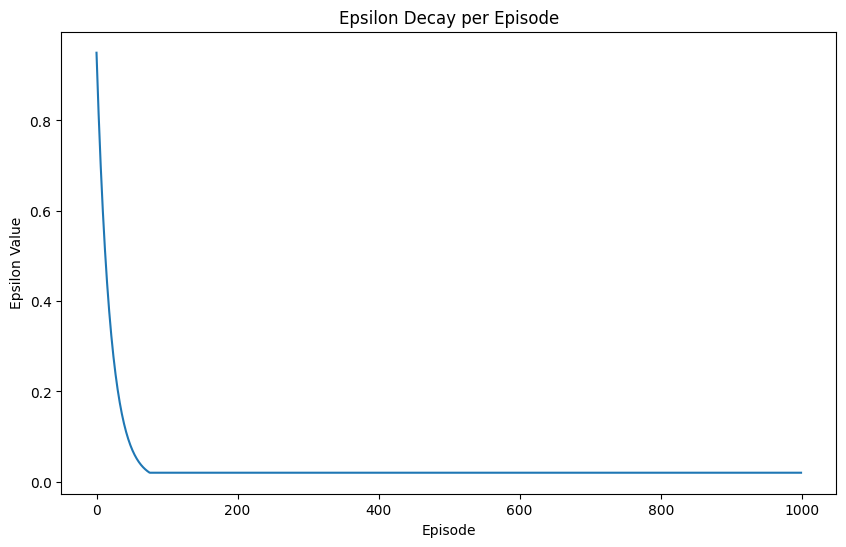

Greedy Episode 1
Total Reward: -1, State:(0, 1) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 1)
Total Reward: -6, State:(2, 1) Next State: (3, 1)
Total Reward: -10, State:(3, 1) Next State: (4, 1)
Total Reward: 10, State:(4, 1) Next State: (5, 1)
Total Reward: 29, State:(5, 1) Next State: (5, 2)
Total Reward: 47, State:(5, 2) Next State: (5, 3)
Total Reward: 164, State:(5, 3) Next State: (5, 4)
Greedy Episode 2
Total Reward: -1, State:(0, 1) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 1)
Total Reward: -6, State:(2, 1) Next State: (3, 1)
Total Reward: -10, State:(3, 1) Next State: (4, 1)
Total Reward: 10, State:(4, 1) Next State: (5, 1)
Total Reward: 29, State:(5, 1) Next State: (5, 2)
Total Reward: 47, State:(5, 2) Next State: (5, 3)
Total Reward: 164, State:(5, 3) Next State: (5, 4)
Greedy Episode 3
Total Reward: -1, State:(0, 1) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 1)
Total Reward: -6, State:(2, 1) Next State: (3

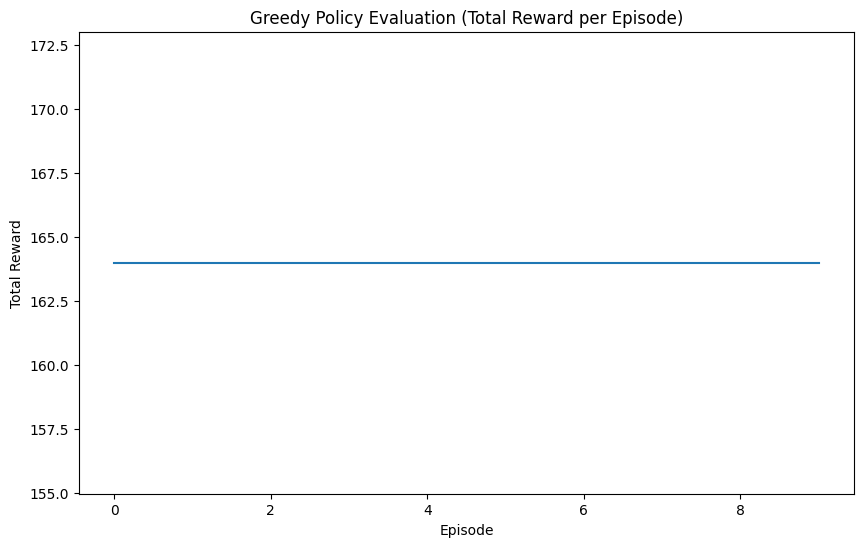

In [6]:

item_positions = [(1, 4), (2, 5), (3, 4), (1, 3), (5, 1)]
start_position=(0, 1)
goal_position=(5, 4)

env = GridWorld(start_position=start_position, goal_position=goal_position, item_positions=item_positions)
episodes = 1000
alpha = 0.1 
discount = 0.99
epsilon = 1
epsilon_min = 0.0199
epsilon_decay = 0.95

Q_values, initial_Q_values, total_rewards, epsilon_values = sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay, start_position, goal_position, item_positions)


states = [(i // 6, i % 6) for i in range(env.state_space)]
action_columns = env.action_names
initial_q_table_df = pd.DataFrame(initial_Q_values, index=[f"State {state}" for state in states], columns=action_columns)
final_q_table_df = pd.DataFrame(Q_values, index=[f"State {state}" for state in states], columns=action_columns)

print("Initial Q-table:")
print(initial_q_table_df)
print("\nTrained Q-table after SARSA:")
print(final_q_table_df)

plt.figure(figsize=(10, 6))
plt.plot(range(episodes), total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(episodes), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay per Episode')
plt.show()

greedy_rewards = []
for episode in range(10):
    print(f"Greedy Episode {episode+1}")
    state = env.reset(start_position, goal_position, item_positions)
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(Q_values[state[0] * 6 + state[1]])
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        print(f"Total Reward: {total_reward}, State:{state} Next State: {next_state}")
        state = next_state
        if state == goal_position:
            done = True

    greedy_rewards.append(total_reward)

plt.figure(figsize=(10, 6))
plt.plot(range(10), greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation (Total Reward per Episode)')
plt.show()
